In [ ]:
! pip install ultralytics --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="SqxHxUmH1bESmMpTc8Wo")
project = rf.workspace("field-planttutorial").project("field-plant")
version = project.version(2)
dataset = version.download("yolov11")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Field-plant-2 in yolov11:: 100%|██████████| 9862/9862 [00:57<00:00, 170.16it/s]


In [ ]:
# Import necessary libraries
import torch
import os
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from roboflow import Roboflow
from ultralytics import YOLO
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import pandas as pd
from collections import Counter

labels_path = "Field-plant-2/train/labels"

label_files = os.listdir(labels_path)

class_counts = Counter()

for file in label_files:
    with open(os.path.join(labels_path, file), "r") as f:
        for line in f:
            class_id = line.split()[0]
            class_counts[class_id] += 1

df = pd.DataFrame(class_counts.items(), columns=["Class ID", "Count"])
print(df.sort_values("Count", ascending=True))



   Class ID  Count
15        6      1
18       16      6
19       12      7
22       13      8
25       25     11
24       17     13
20       10     13
14        0     17
12        7     21
21        8     27
23       20     30
17       11     33
6         4     50
13       26     75
3        15    113
10        9    115
5         1    128
11        5    156
16       14    180
8        24    190
7        23    273
9         2    286
1        18    338
2        21   1142
4        19   1164
0         3   1367


In [ ]:
if class_id in ['6', '16', '12', '13', '25']:  # Undersampled classes
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.5),  # Higher probability
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=0.7),
        A.Rotate(limit=30, p=0.7),  # More aggressive rotation
        A.Blur(blur_limit=3, p=0.3),
        A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5)  # Add cutout for more diversity
    ])
else:
    transform = A.Compose([
        A.Resize(640, 640),
        A.RandomBrightnessContrast(p=0.2),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.Blur(blur_limit=3, p=0.2)
    ])


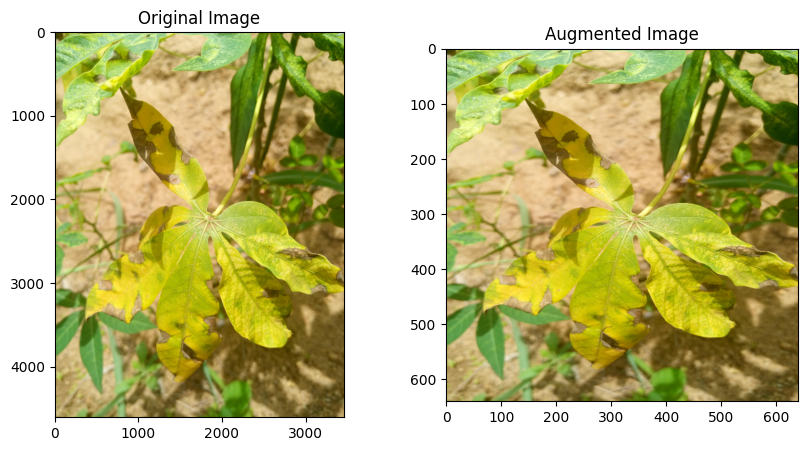

In [ ]:
# Path to training images and labels
train_images_path = "Field-plant-2/train/images/"
train_labels_path = "Field-plant-2/train/labels/"

# Load and preprocess a sample image
sample_image_path = os.path.join(train_images_path, os.listdir(train_images_path)[0])
image = cv2.imread(sample_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
augmented = transform(image=image)["image"]

# Display the original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[1].imshow(augmented)
ax[1].set_title("Augmented Image")
plt.show()

In [ ]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Feature Mapping using PCA
def feature_mapping(image_path, pca_components=10):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (64, 64))  # Resize to 64x64
    img_flat = img.reshape(64, 64)  # Keep 2D structure

    scaler = StandardScaler()
    img_scaled = scaler.fit_transform(img_flat)  # Normalize pixel values

    pca = PCA(n_components=min(pca_components, img_scaled.shape[1]))  # Ensure valid component count
    img_pca = pca.fit_transform(img_scaled)  # Apply PCA

    return img_pca

# Test with sample image
feature_map = feature_mapping(sample_image_path, pca_components=10)
print("Feature Mapping Output Shape:", feature_map.shape)


Feature Mapping Output Shape: (64, 10)


In [ ]:
import matplotlib
matplotlib.use('Agg')




In [ ]:
!nvidia-smi


Tue Apr  8 05:17:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!yolo detect train \
    data=/content/Field-plant-2/data.yaml \
    model=yolov8l.pt \
    epochs=10 \
    batch=16 \
    imgsz=640 \
    lr0=0.0001 \
    iou=0.7 \
    optimizer=AdamW \
    weight_decay=0.0005 \
    momentum=0.9 \
    hsv_h=0.02 hsv_s=0.8 hsv_v=0.5 \
    mosaic=1.0 mixup=0.3 dropout=0.3 copy_paste=0.2 \
    cos_lr=True \
    plots=False \
    project=/content/Field-plant-2/training_results \
    name=run_finetuned_v3



Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/Field-plant-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/Field-plant-2/training_results, name=run_finetuned_v32, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.3, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

In [ ]:
!yolo detect val \
    data=/content/Field-plant-2/data.yaml \
    model=/content/Field-plant-2/training_results/run_finetuned_v3/weights/best.pt \
    batch=16 \
    imgsz=640 \
    iou=0.8 \
    split=val \
    project=/content/Field-plant-2/training_results \
    name=val_results



Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,627,425 parameters, 0 gradients, 164.9 GFLOPs
val: Scanning /content/Field-plant-2/valid/labels.cache... 734 images, 0 backgrounds, 0 corrupt: 100% 734/734 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 46/46 [00:52<00:00,  1.15s/it]
                   all        734       1226      0.555      0.381      0.362      0.276
Cassava Bacterial Blight          3          4          1          0     0.0577     0.0471
Cassava Brown Leaf Spot         27         28      0.348      0.457      0.279      0.235
       Cassava Healthy         47         63      0.462      0.571      0.542      0.407
        Cassava Mosaic        150        272      0.599      0.864      0.789      0.573
      Cassava Root Rot         17         18          1          0      0.542      0.341
      Corn Brown Spots         30         3

In [ ]:
!yolo detect val \
    data=/content/Field-plant-2/data.yaml \
    model=/content/Field-plant-2/training_results/run_finetuned_v3/weights/best.pt \
    batch=16 \
    imgsz=640 \
    iou=0.8 \
    split=test \
    project=/content/Field-plant-2/training_results \
    name=test_results



Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 43,627,425 parameters, 0 gradients, 164.9 GFLOPs
val: Scanning /content/Field-plant-2/test/labels... 737 images, 0 backgrounds, 0 corrupt: 100% 737/737 [00:01<00:00, 388.94it/s]
val: New cache created: /content/Field-plant-2/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 47/47 [00:53<00:00,  1.15s/it]
                   all        737       1207      0.579       0.32      0.373      0.295
Cassava Bacterial Blight          2          4          1          0      0.251       0.25
Cassava Brown Leaf Spot         30         37       0.64      0.289      0.398      0.344
       Cassava Healthy         40         68      0.576      0.485      0.531      0.387
        Cassava Mosaic        159        251      0.695      0.744       0.79      0.588
      Cassava Root Rot          8          9          1          

In [ ]:
!zip -r field-plant-project.zip Field-plant-2 yolov8l.pt yolo11n.pt



Streaming output truncated to the last 5000 lines.
  adding: Field-plant-2/train/images/Mais_Jaunissement_-131-_jpg.rf.cabe650f56c5ea66316ff517697d0700.jpg (deflated 1%)
  adding: Field-plant-2/train/images/Tomate_Taches_Brunes-350-_jpg.rf.8592c35decfd22e25d581b3d00fc8fea.jpg (deflated 1%)
  adding: Field-plant-2/train/images/Mais_Taches-Jaunes_-34-_jpg.rf.83fe3d3fe2bc6f6a3dbe0a5b5bca4c78.jpg (deflated 1%)
  adding: Field-plant-2/train/images/Manioc_Bacteriose-15-_jpg.rf.010d991284f11ba0927d2250ef8b650c.jpg (deflated 0%)
  adding: Field-plant-2/train/images/Mais_Striure_-67-_jpg.rf.6361aee7fa3cacbe4c1b5bf0553fbd65.jpg (deflated 0%)
  adding: Field-plant-2/train/images/Mais_brulures_feuilles-52-_jpg.rf.1f620e18939129ba843940723322b6b3.jpg (deflated 1%)
  adding: Field-plant-2/train/images/Mais_Taches-Brunes_-36-_jpg.rf.65a47f935583dcf18076d326a70349cb.jpg (deflated 1%)
  adding: Field-plant-2/train/images/Manioc_Bacteriose-87-_jpg.rf.e7170b7ba2106a92ccd2f4dedccf3b13.jpg (deflated 1%)
  